# Check energy and force distribution for each molecule

In [1]:
import os, sys, math
import numpy as np
import pandas as pd
import qcportal as ptl
from collections import Counter
from openff.toolkit.topology import Molecule

In [2]:
HARTEE_TO_KCALPERMOL = 627.5
BOHR_TO_ANGSTROMS = 0.529177249

In [3]:
client =ptl.FractalClient()
ds = client.get_collection("Dataset", "RNA Single Point Dataset v1.0")

In [4]:
#recs_wb97m = ds.get_records(method='wb97m-d3bj', basis='def2-tzvppd', program='psi4', keywords='wb97m-d3bj/def2-tzvppd')
#print("No. of records: ", len(recs_wb97m))

In [5]:
recs_default = ds.get_records(method='b3lyp-d3bj', basis='dzvp', program='psi4', keywords='default')
print("length of dataframe", len(recs_default), "\n", "No. of records in each: ",  len(recs_default[0]), len(recs_default[1]))

length of dataframe 2 
 No. of records in each:  4489 4489


In [7]:
count = 0
mydata = []

# Combining two energies
# Some calculations failed due to SCF convergence errors, so excluding those by checking the record status of b3lyp calculation
for i in range(len(recs_default[0])):
    if recs_default[1].iloc[i].record.status == 'COMPLETE':
        print(count, " B3LYP + D3BJ energy of ", recs_default[1].iloc[i].name, recs_default[1].iloc[i].record.properties.return_energy + recs_default[0].iloc[i].record.properties.return_energy)
   
        entry_id = i
        record_id = recs_default[1].iloc[i].record.id
        mol_id = recs_default[1].iloc[i].record.molecule
        energy = recs_default[1].iloc[i].record.properties.return_energy + recs_default[0].iloc[i].record.properties.return_energy

        _grad1 = recs_default[0].iloc[i].record.return_result
        _grad2 = recs_default[1].iloc[i].record.return_result
        grad = _grad1 + _grad2
        forces = [ np.linalg.norm(v) for v in grad ]
        #forces = np.array(forces) * HARTEE_TO_KCALPERMOL / BOHR_TO_ANGSTROMS   # kcal/mol/angstrom
        
        natoms = len(forces)
        
        # get smiles
        record_name = recs_default[1].iloc[i].name
        _smi = record_name.split('-')
        if len(_smi) == 1:
            smi = _smi[0]
        else:
            smi = "".join(_smi[:-1])


        # check conformers
        try:
            conf_id = record_name.split('-')[-1]
        except:
            conf_id = 0


        # name and formula
        #name = client.query_molecules(recs_default[1].iloc[-i].record.molecule)[0].name
        #formula = client.query_molecules(recs_default[1].iloc[-i].record.molecule)[0].get_molecular_formula()

        
        # define nucleotide type
        nb = [ s for s in smi if s == "." ]
        if len(nb) == 0:
            nbtype = "trinucleotide"
        elif len(nb) == 1:
            nbtype = "base pair"
        elif len(nb) == 2:
            nbtype = "base triple"
        else:
            print("unknown base type")

            
        mydata.append([entry_id, record_id, mol_id, smi, conf_id, natoms, energy, forces, nbtype])

        
        count += 1

0  B3LYP + D3BJ energy of  Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1.Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1-0 -1782.639713836192
1  B3LYP + D3BJ energy of  Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1.Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1-1 -1782.6302990214972
2  B3LYP + D3BJ energy of  Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1.Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1-2 -1782.641790205362
3  B3LYP + D3BJ energy of  Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1.Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1-3 -1782.62233649516
4  B3LYP + D3BJ energy of  Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1.Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1-4 -1782.648962953126
5  B3LYP + D3BJ energy of  Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1.Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1-5 -1782.6406730116719
6  B3LYP + D3BJ energy of  Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1.Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n

In [8]:
cols = ["ENTRYID", "RECORDID", "MOLID", "SMILES", "CONFID", "NATOMS", "ENERGY", "FORCE", "TYPE"]
df = pd.DataFrame(mydata, columns=cols)

In [9]:
df

,ENTRYID,RECORDID,MOLID,SMILES,CONFID,NATOMS,ENERGY,FORCE,TYPE
0,0,109522131,102478519,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,0,60,-1782.639714,"[0.018726365593458357, 0.008252388883226549, 0...",base pair
1,1,109522262,102478520,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,1,60,-1782.630299,"[0.01662959115297244, 0.007945066117722829, 0....",base pair
2,2,109522115,102478521,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,2,60,-1782.641790,"[0.02237975147937724, 0.0068043726832276935, 0...",base pair
3,3,109522209,102478522,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,3,60,-1782.622336,"[0.018269737336652016, 0.009020020405460075, 0...",base pair
4,4,109522302,102478523,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,4,60,-1782.648963,"[0.017538339841151794, 0.007899933770061943, 0...",base pair
...,...,...,...,...,...,...,...,...,...
4376,4484,109520666,102477790,O=c1ccn([C@@H]2O[C@H](COP(=O)([O])O[C@@H]3[C@@...,73,89,-3715.220660,"[0.02006876358199061, 0.007693179721829506, 0....",trinucleotide
4377,4485,109520669,102477791,O=c1ccn([C@@H]2O[C@H](COP(=O)([O])O[C@@H]3[C@@...,74,89,-3715.216407,"[0.025388088859212617, 0.009023541693816976, 0...",trinucleotide
4378,4486,109520695,102477792,O=c1ccn([C@@H]2O[C@H](COP(=O)([O])O[C@@H]3[C@@...,75,89,-3715.197436,"[0.01920532125712759, 0.01245826700387837, 0.0...",trinucleotide
4379,4487,109520672,102477725,O=c1ccn([C@@H]2O[C@H](COP(=O)([O])O[C@@H]3[C@@...,8,89,-3715.204625,"[0.019332061482389536, 0.007397386066061015, 0...",trinucleotide


check if number of unique molecules matches original qca submission https://github.com/openforcefield/qca-dataset-submission/tree/master/submissions/2022-07-07-RNA-basepair-triplebase-single-points

In [10]:
assert len(df.SMILES.unique()) == 94

In [11]:
mylist = df.SMILES.unique().tolist()
mylist

['Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1.Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1',
 'Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1.Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1.Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1',
 'Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1.Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1.Nc1nc2c(ncn2[C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)[nH]1',
 'Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1.Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1.Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
 'Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1.Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1.O=c1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)[nH]1',
 'Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1.Nc1nc2c(ncn2[C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)[nH]1',
 'Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1.Nc1nc2c(ncn2[C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)[nH]1.Nc1nc2c(ncn2[C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)[nH]1',
 'Nc1c

In [12]:
# loop over each unique molecule (smiles) and calculate relative energy respect to minima
uid = 0
for s in mylist:
    #print(s)
    _df = df[df["SMILES"] == s]
    
    n_conf = len(_df)
    arr = _df.ENERGY.to_numpy() - _df.ENERGY.to_numpy().min()   # hartee

    #idx = np.where(arr > 1)
    #if len(idx[0]) != 0:
    #    print("{}: {} hartee relative to minima structure".format(s, arr[idx]))

    
    # get row index
    for i, idx in enumerate(_df.index):
        df.loc[idx, "N_CONF"] = n_conf
        df.loc[idx, "RELATIVE_ENERGY_HARTEE"] = arr[i]
        df.loc[idx, "RELATIVE_ENERGY_KCALPERMOL"] = arr[i] * HARTEE_TO_KCALPERMOL
        df.loc[idx, "RELATIVE_ENERGY_KCALPERMOL_PER_ATOM"] = arr[i] * HARTEE_TO_KCALPERMOL / int(df.loc[idx, "NATOMS"])
        df.loc[idx, "UID"] = uid
        
    uid += 1

In [13]:
df

,ENTRYID,RECORDID,MOLID,SMILES,CONFID,NATOMS,ENERGY,FORCE,TYPE,N_CONF,RELATIVE_ENERGY_HARTEE,RELATIVE_ENERGY_KCALPERMOL,RELATIVE_ENERGY_KCALPERMOL_PER_ATOM,UID
0,0,109522131,102478519,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,0,60,-1782.639714,"[0.018726365593458357, 0.008252388883226549, 0...",base pair,9.0,0.009249,5.803821,0.096730,0.0
1,1,109522262,102478520,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,1,60,-1782.630299,"[0.01662959115297244, 0.007945066117722829, 0....",base pair,9.0,0.018664,11.711617,0.195194,0.0
2,2,109522115,102478521,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,2,60,-1782.641790,"[0.02237975147937724, 0.0068043726832276935, 0...",base pair,9.0,0.007173,4.500899,0.075015,0.0
3,3,109522209,102478522,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,3,60,-1782.622336,"[0.018269737336652016, 0.009020020405460075, 0...",base pair,9.0,0.026626,16.708102,0.278468,0.0
4,4,109522302,102478523,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,4,60,-1782.648963,"[0.017538339841151794, 0.007899933770061943, 0...",base pair,9.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4376,4484,109520666,102477790,O=c1ccn([C@@H]2O[C@H](COP(=O)([O])O[C@@H]3[C@@...,73,89,-3715.220660,"[0.02006876358199061, 0.007693179721829506, 0....",trinucleotide,76.0,0.029826,18.715976,0.210292,93.0
4377,4485,109520669,102477791,O=c1ccn([C@@H]2O[C@H](COP(=O)([O])O[C@@H]3[C@@...,74,89,-3715.216407,"[0.025388088859212617, 0.009023541693816976, 0...",trinucleotide,76.0,0.034079,21.384686,0.240277,93.0
4378,4486,109520695,102477792,O=c1ccn([C@@H]2O[C@H](COP(=O)([O])O[C@@H]3[C@@...,75,89,-3715.197436,"[0.01920532125712759, 0.01245826700387837, 0.0...",trinucleotide,76.0,0.053050,33.288600,0.374029,93.0
4379,4487,109520672,102477725,O=c1ccn([C@@H]2O[C@H](COP(=O)([O])O[C@@H]3[C@@...,8,89,-3715.204625,"[0.019332061482389536, 0.007397386066061015, 0...",trinucleotide,76.0,0.045860,28.777461,0.323342,93.0


In [14]:
df.sort_values(by=['SMILES', 'RELATIVE_ENERGY_HARTEE'])

,ENTRYID,RECORDID,MOLID,SMILES,CONFID,NATOMS,ENERGY,FORCE,TYPE,N_CONF,RELATIVE_ENERGY_HARTEE,RELATIVE_ENERGY_KCALPERMOL,RELATIVE_ENERGY_KCALPERMOL_PER_ATOM,UID
4,4,109522302,102478523,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,4,60,-1782.648963,"[0.017538339841151794, 0.007899933770061943, 0...",base pair,9.0,0.000000,0.000000,0.000000,0.0
2,2,109522115,102478521,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,2,60,-1782.641790,"[0.02237975147937724, 0.0068043726832276935, 0...",base pair,9.0,0.007173,4.500899,0.075015,0.0
5,5,109522167,102478524,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,5,60,-1782.640673,"[0.01664261765499945, 0.009479755862102614, 0....",base pair,9.0,0.008290,5.201938,0.086699,0.0
0,0,109522131,102478519,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,0,60,-1782.639714,"[0.018726365593458357, 0.008252388883226549, 0...",base pair,9.0,0.009249,5.803821,0.096730,0.0
6,6,109522304,102478525,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,6,60,-1782.639590,"[0.01684551978383726, 0.007655335394582195, 0....",base pair,9.0,0.009373,5.881839,0.098031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4373,4481,109520535,102477787,O=c1ccn([C@@H]2O[C@H](COP(=O)([O])O[C@@H]3[C@@...,70,89,-3715.149320,"[0.01736060846315641, 0.008010799929649636, 0....",trinucleotide,76.0,0.101166,63.481547,0.713276,93.0
4309,4417,109520708,102477729,O=c1ccn([C@@H]2O[C@H](COP(=O)([O])O[C@@H]3[C@@...,12,89,-3715.144137,"[0.017633902821269358, 0.009599775427531706, 0...",trinucleotide,76.0,0.106349,66.734115,0.749822,93.0
4332,4440,109520628,102477750,O=c1ccn([C@@H]2O[C@H](COP(=O)([O])O[C@@H]3[C@@...,33,89,-3715.142594,"[0.01734449691196838, 0.006825716038329852, 0....",trinucleotide,76.0,0.107891,67.701858,0.760695,93.0
4349,4457,109520567,102477766,O=c1ccn([C@@H]2O[C@H](COP(=O)([O])O[C@@H]3[C@@...,49,89,-3715.126673,"[0.016373718784259052, 0.00785336612719866, 0....",trinucleotide,76.0,0.123813,77.692800,0.872953,93.0


In [15]:
df[df["RELATIVE_ENERGY_HARTEE"] > 1]

,ENTRYID,RECORDID,MOLID,SMILES,CONFID,NATOMS,ENERGY,FORCE,TYPE,N_CONF,RELATIVE_ENERGY_HARTEE,RELATIVE_ENERGY_KCALPERMOL,RELATIVE_ENERGY_KCALPERMOL_PER_ATOM,UID
13,18,109522573,102478633,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,16,93,-2815.359038,"[0.03556394326387403, 0.030114507404674563, 0....",base triple,11.0,6.307843,3958.171476,42.560984,2.0
19,25,109522625,102478625,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,8,93,-2813.786549,"[0.04077036051347164, 0.026579746693429943, 0....",base triple,11.0,7.880332,4944.908623,53.171060,2.0
20,26,109522609,102478626,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,9,93,-2815.451005,"[0.03790055452867765, 0.029644654533732672, 0....",base triple,11.0,6.215876,3900.462036,41.940452,2.0
23,29,109522860,102478858,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,10,92,-2740.686506,"[0.3991860030243061, 0.05851612255112474, 0.13...",base triple,9.0,5.696453,3574.524329,38.853525,3.0
26,32,109522875,102478852,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,4,92,-2739.828865,"[0.010831746227354234, 0.00908277654531234, 0....",base triple,9.0,6.554094,4112.693817,44.703194,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3672,3765,109522283,102478550,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1...,3,61,-1870.611054,"[0.35163214081956173, 0.07857639785905397, 0.0...",base pair,15.0,4.341219,2724.114974,44.657623,82.0
3674,3767,109522146,102478552,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1...,5,61,-1870.567036,"[0.3242819581866643, 0.039830875600977284, 0.0...",base pair,15.0,4.385237,2751.736440,45.110433,82.0
3679,3776,109522641,102478701,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1...,12,90,-2778.864181,"[0.26810578045737743, 0.06203335491432377, 0.1...",base triple,4.0,7.285584,4571.703852,50.796709,83.0
3680,3781,109522639,102478706,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1...,17,90,-2778.973504,"[0.22470568682066164, 0.06019315625439709, 0.0...",base triple,4.0,7.176261,4503.103879,50.034488,83.0


In [16]:
df[df["RELATIVE_ENERGY_HARTEE"] <= 0]

,ENTRYID,RECORDID,MOLID,SMILES,CONFID,NATOMS,ENERGY,FORCE,TYPE,N_CONF,RELATIVE_ENERGY_HARTEE,RELATIVE_ENERGY_KCALPERMOL,RELATIVE_ENERGY_KCALPERMOL_PER_ATOM,UID
4,4,109522302,102478523,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,4,60,-1782.648963,"[0.017538339841151794, 0.007899933770061943, 0...",base pair,9.0,0.0,0.0,0.0,0.0
9,9,109522688,102478688,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,90,-2673.949166,"[0.019080236088626225, 0.008092451240351272, 0...",base triple,1.0,0.0,0.0,0.0,1.0
15,20,109522592,102478620,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,3,93,-2821.666881,"[0.019728685697956664, 0.009313482313971482, 0...",base triple,11.0,0.0,0.0,0.0,2.0
27,33,109522805,102478853,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,5,92,-2746.382959,"[0.018278999835581306, 0.00860019171243245, 0....",base triple,9.0,0.0,0.0,0.0,3.0
30,38,109522863,102478905,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)...,89,-2693.856395,"[0.017939477462671508, 0.007864036204148831, 0...",base triple,1.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4153,4261,109515320,102475020,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O])O[C@@H...,53,95,-3820.258979,"[0.016886552170327376, 0.007082973579316006, 0...",trinucleotide,79.0,0.0,0.0,0.0,89.0
4279,4387,109515717,102475229,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O])O[C@@H...,85,98,-3872.740374,"[0.01735668556832329, 0.007336394022929237, 0....",trinucleotide,112.0,0.0,0.0,0.0,90.0
4296,4404,109522255,102478592,O=c1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O...,1,58,-1822.448318,"[0.018553248167488153, 0.008609367387154634, 0...",base pair,8.0,0.0,0.0,0.0,91.0
4304,4412,109522640,102478687,O=c1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O...,1,87,-2733.668171,"[0.01770955657794898, 0.008694937479615724, 0....",base triple,2.0,0.0,0.0,0.0,92.0


In [17]:
df.RELATIVE_ENERGY_HARTEE.max()

8.860008632659174

In [18]:
df.RELATIVE_ENERGY_KCALPERMOL.max()

5559.655416993632

### plot

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

In [20]:
params = {'legend.fontsize': 40, 
          'font.size': 40, 
          'axes.labelsize': 48,
          'axes.titlesize': 48,
          'xtick.labelsize': 40,
          'ytick.labelsize': 40,
          'savefig.dpi': 600, 
          'figure.figsize': [64, 8],
          'xtick.major.size': 10,
          'xtick.minor.size': 7,
          'ytick.major.size': 10,
          'ytick.minor.size': 7}

plt.rcParams.update(params)

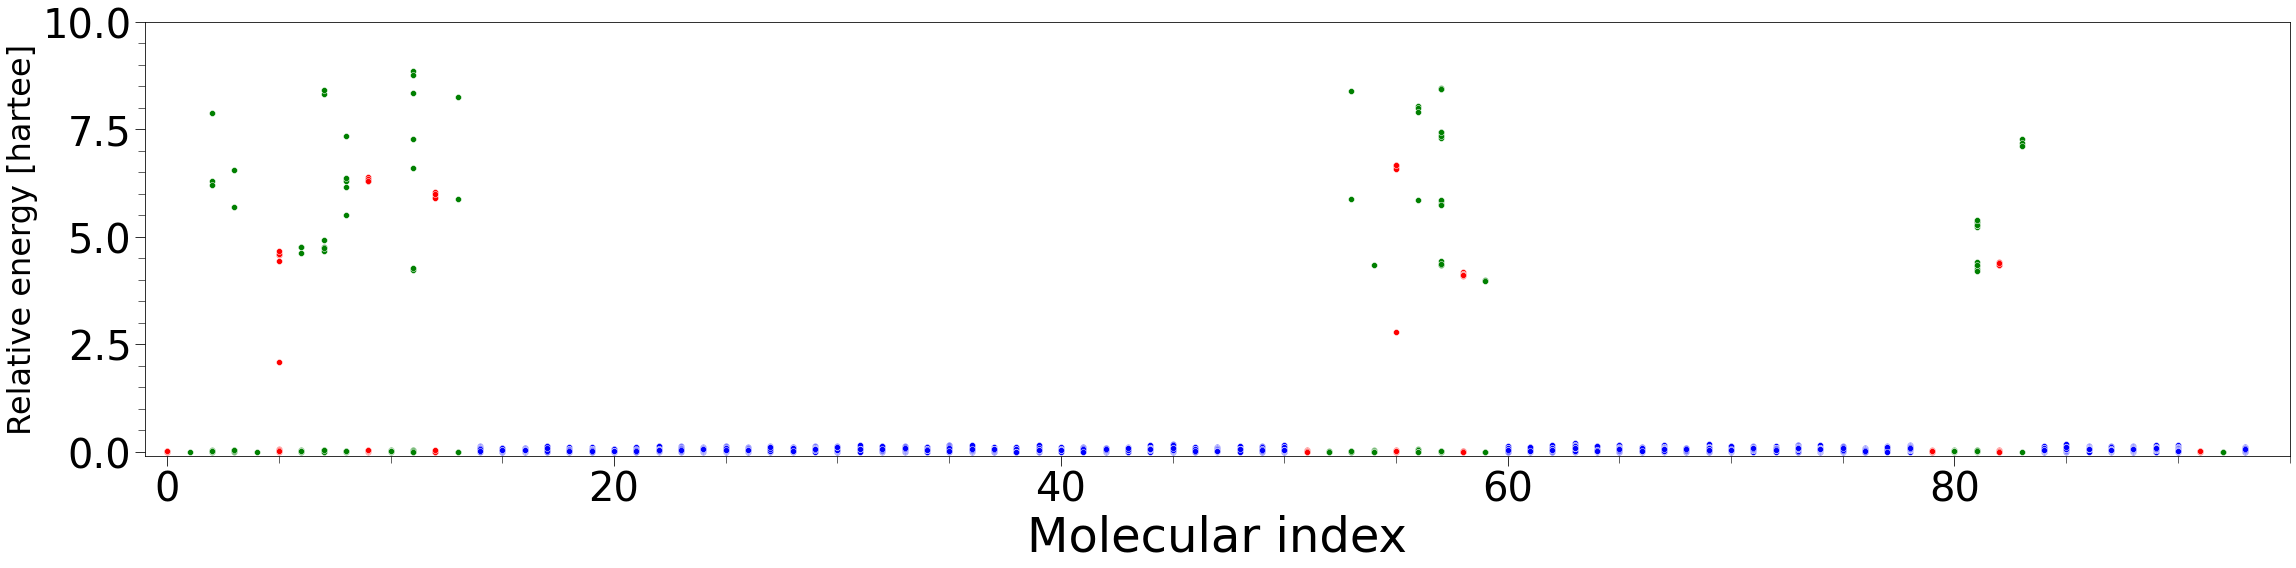

In [21]:
f, ax = plt.subplots(figsize=(32, 8))

# trinucleotide
dataset = df[df["TYPE"] == "trinucleotide"]
sns.scatterplot(data=dataset, x="UID", y="RELATIVE_ENERGY_HARTEE", color="blue")

# base pairs
dataset = df[df["TYPE"] == "base pair"]
sns.scatterplot(data=dataset, x="UID", y="RELATIVE_ENERGY_HARTEE", color="red")

# base triples
dataset = df[df["TYPE"] == "base triple"]
sns.scatterplot(data=dataset, x="UID", y="RELATIVE_ENERGY_HARTEE", color="green")


ax.set_xlim(-1, uid+1)
ax.set_ylim(-0.1, round(df.RELATIVE_ENERGY_HARTEE.max()+1))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.set_xlabel("Molecular index")
ax.set_ylabel("Relative energy [hartee]",size=32)

#ax.set_yscale("log", base=10)
plt.tight_layout()
plt.savefig("energy_distribution_hartee.png")

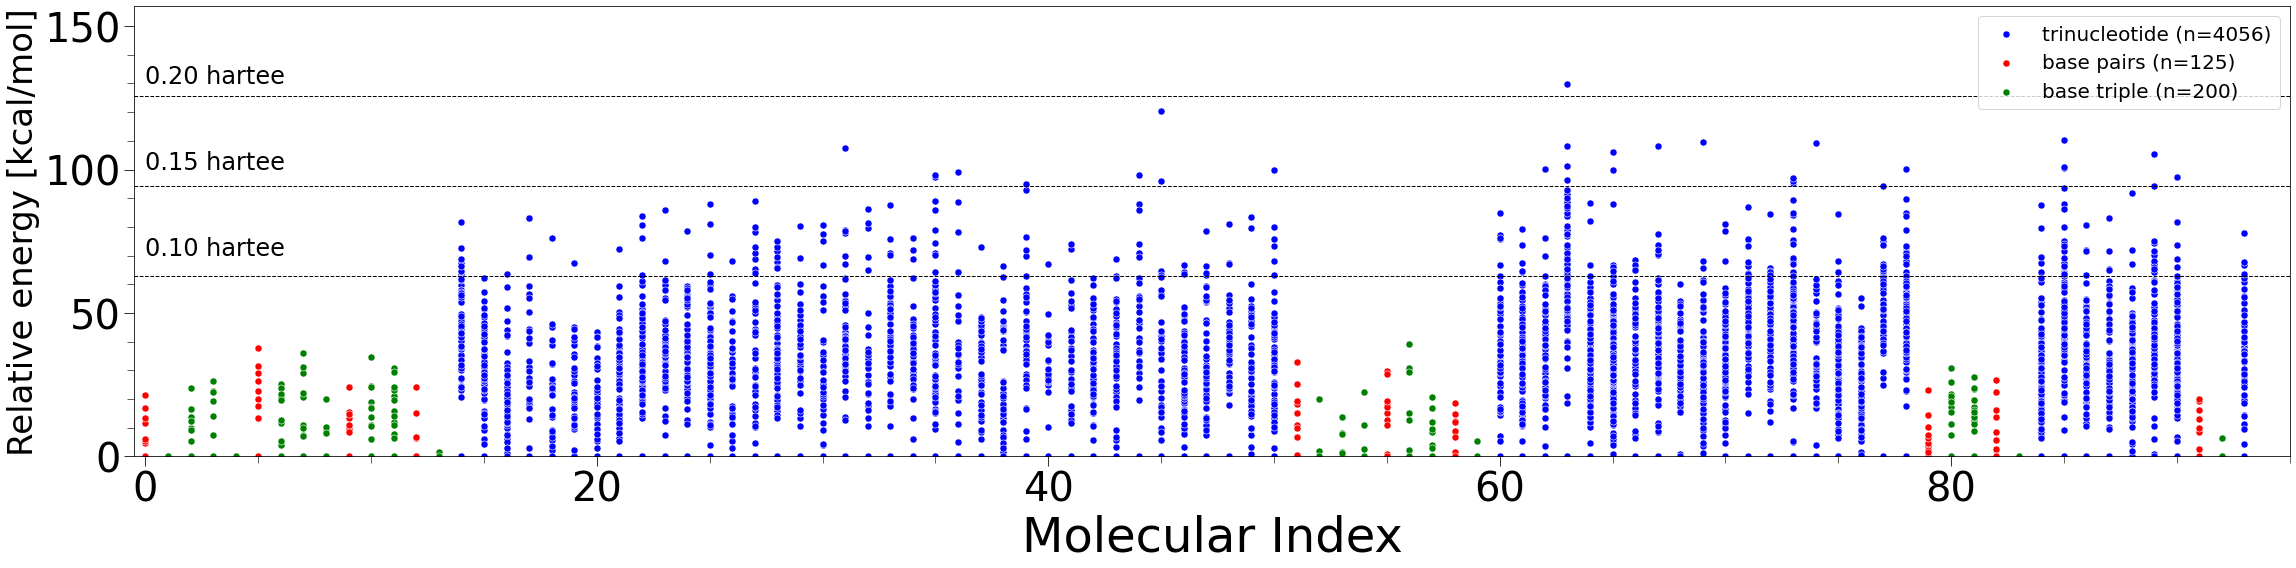

In [22]:
f, ax = plt.subplots(figsize=(32, 8))

# trinucleotide
dataset = df[df["TYPE"] == "trinucleotide"]
sns.scatterplot(data=dataset, x="UID", y="RELATIVE_ENERGY_KCALPERMOL", color="blue", s=50, label="trinucleotide (n={})".format(len(dataset)))

# base pair
dataset = df[df["TYPE"] == "base pair"]
sns.scatterplot(data=dataset, x="UID", y="RELATIVE_ENERGY_KCALPERMOL", color="red", s=50, label="base pairs (n={})".format(len(dataset)))

# base triple
dataset = df[df["TYPE"] == "base triple"]
sns.scatterplot(data=dataset, x="UID", y="RELATIVE_ENERGY_KCALPERMOL", color="green", s=50, label="base triple (n={})".format(len(dataset)))

ax.set_xlim(-0.5, uid+1)
ax.set_ylim(0, HARTEE_TO_KCALPERMOL*2.5/10)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.axhline(y=HARTEE_TO_KCALPERMOL/10, c='k', ls='--', lw=1)
ax.text(0, 70, "0.10 hartee", fontsize=24)

ax.axhline(y=HARTEE_TO_KCALPERMOL*1.5/10, c='k', ls='--', lw=1)
ax.text(0, 100, "0.15 hartee", fontsize=24)

ax.axhline(y=HARTEE_TO_KCALPERMOL*2/10, c='k', ls='--', lw=1)
ax.text(0, 130, "0.20 hartee", fontsize=24)

ax.set_xlabel("Molecular Index")
ax.set_ylabel("Relative energy [kcal/mol]",size=34)

ax.legend(loc="upper right", bbox_to_anchor=(1.00, 1.00), fontsize=20)

plt.tight_layout()
plt.savefig("energy_distribution_kcalpermol.png")

#### plot energy per atom

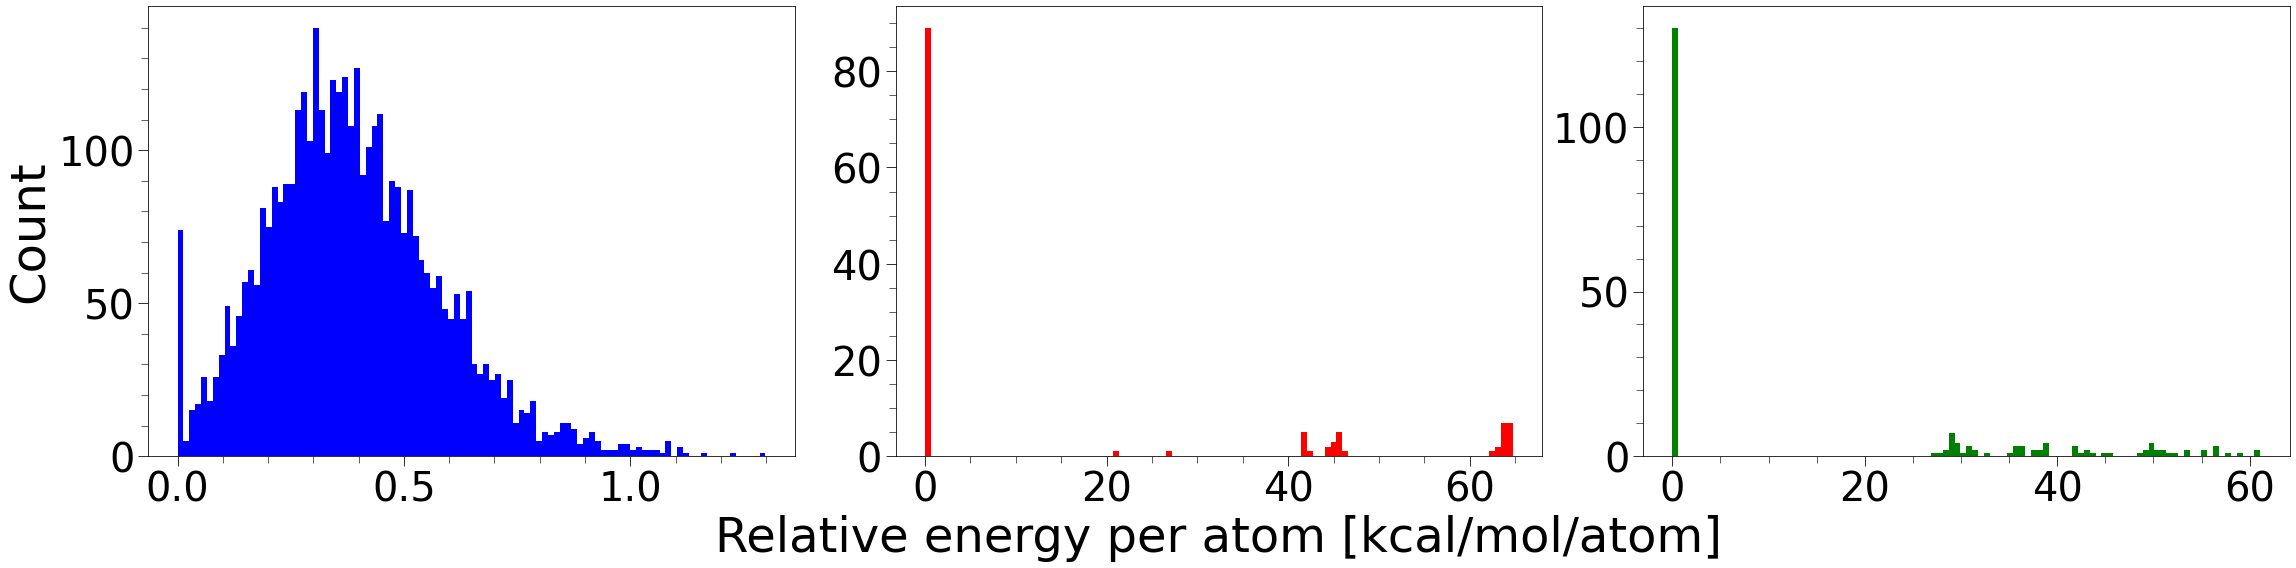

In [187]:
# histogram
#fig, ax = plt.subplots(figsize=(32, 8))
fig = plt.figure(figsize=(32,8))

ax1 = fig.add_subplot(131)
ax1.hist(df[df["TYPE"] == "trinucleotide"]["RELATIVE_ENERGY_KCALPERMOL_PER_ATOM"], bins=100, color='blue')
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax2 = fig.add_subplot(132)
ax2.hist(df[df["TYPE"] == "base pair"]["RELATIVE_ENERGY_KCALPERMOL_PER_ATOM"], bins=100, color='red')
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax3 = fig.add_subplot(133)
ax3.hist(df[df["TYPE"] == "base triple"]["RELATIVE_ENERGY_KCALPERMOL_PER_ATOM"], bins=100, color='green')
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())

ax1.set_ylabel("Count")
ax2.set_xlabel("Relative energy per atom [kcal/mol/atom]")

plt.tight_layout()
plt.savefig("energy_distribution_per_atom.png")
#plt.show()

#### plot forces

In [188]:
f = df[df["TYPE"] == "trinucleotide"]["FORCE"]
arr = []
for _f in f:
    for _ in _f:
        arr.append(_)
arr_trinucleotide = np.array(arr) * HARTEE_TO_KCALPERMOL / BOHR_TO_ANGSTROMS
#arr_trinucleotide = np.array(arr)


f = df[df["TYPE"] == "base pair"]["FORCE"]
arr = []
for _f in f:
    for _ in _f:
        arr.append(_)
arr_basepair = np.array(arr) * HARTEE_TO_KCALPERMOL / BOHR_TO_ANGSTROMS
#arr_basepair = np.array(arr)


f = df[df["TYPE"] == "base triple"]["FORCE"]
arr = []
for _f in f:
    for _ in _f:
        arr.append(_)
arr_basetriple = np.array(arr) * HARTEE_TO_KCALPERMOL / BOHR_TO_ANGSTROMS
#arr_basetriple = np.array(arr)

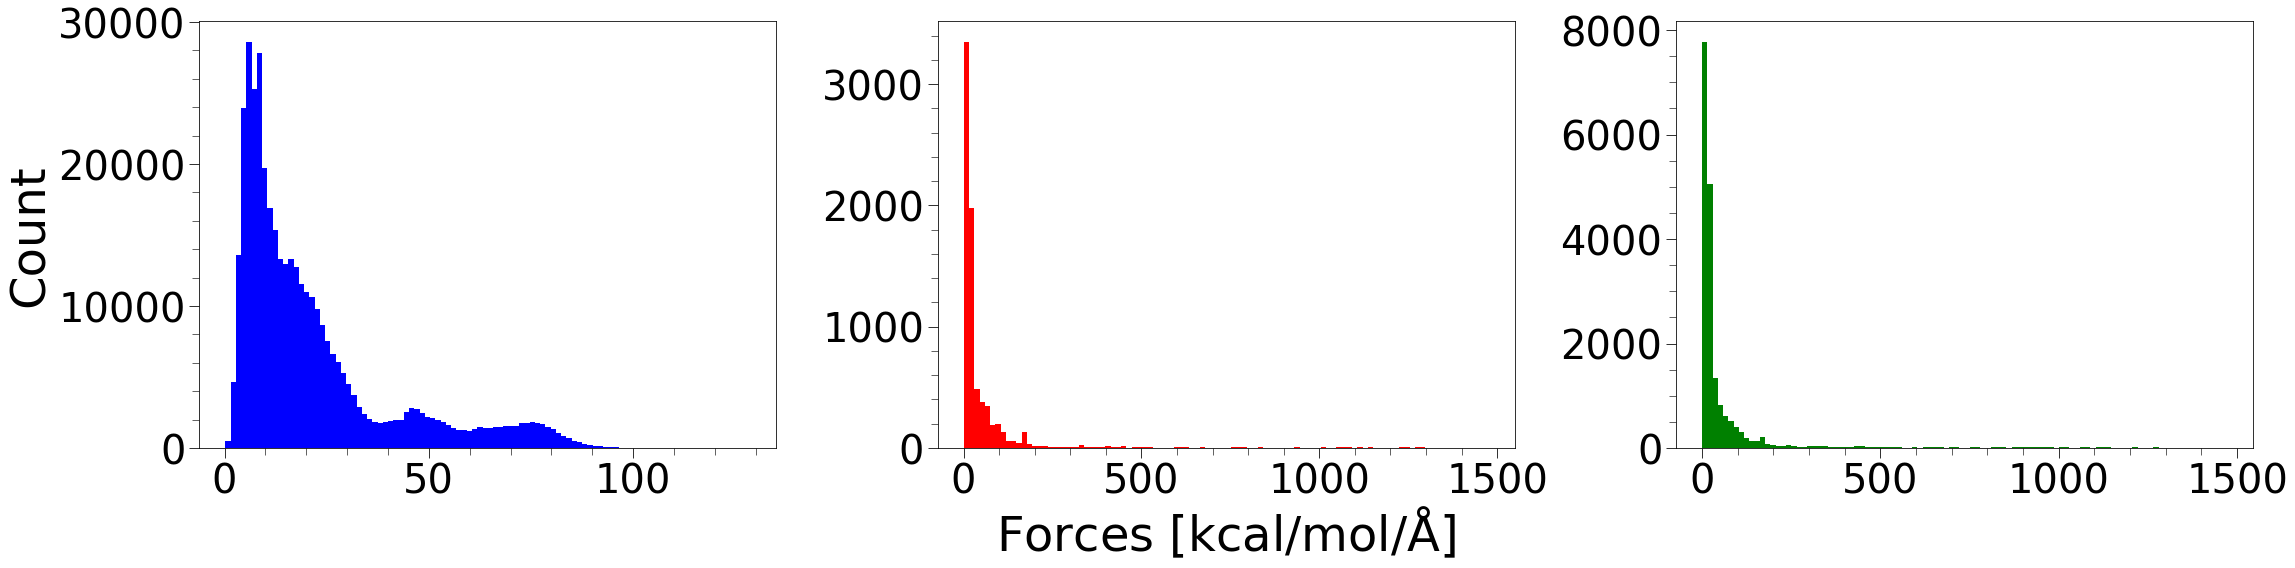

In [256]:
#fig, ax = plt.subplots(figsize=(32, 8))
fig = plt.figure(figsize=(32,8))

#ax.hist(arr_trinucleotide, bins=100, color='blue')
#ax.hist(arr_basepair, bins=100, color='red')
#ax.hist(arr_basetriple, bins=100, color='green')

ax1 = fig.add_subplot(131)
ax1.hist(arr_trinucleotide, bins=100, color='blue')
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax2 = fig.add_subplot(132)
ax2.hist(arr_basepair, bins=100, color='red')
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax3 = fig.add_subplot(133)
ax3.hist(arr_basetriple, bins=100, color='green')
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())

ax1.set_ylabel("Count")
ax2.set_xlabel(r"Forces [kcal/mol/${\rm \AA}$]")

plt.tight_layout()
#plt.show()
plt.savefig("force_distribution.png")

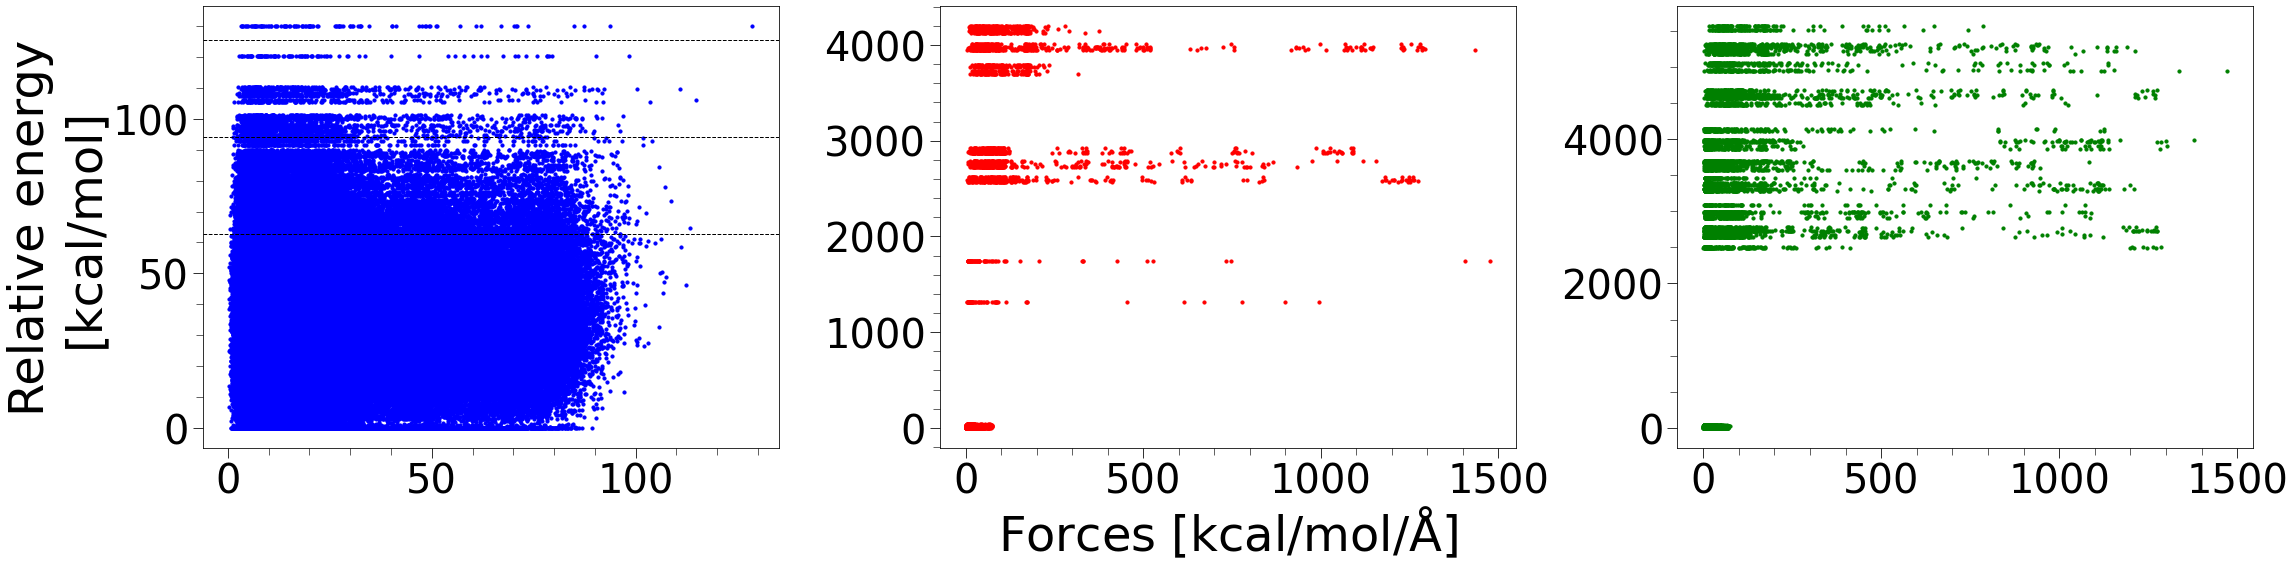

In [258]:
fig = plt.figure(figsize=(32,8))


ax1 = fig.add_subplot(131)
f = df[df["TYPE"] == "trinucleotide"]["FORCE"]
y = df[df["TYPE"] == "trinucleotide"]["RELATIVE_ENERGY_KCALPERMOL"]
for i in range(len(y)):    
    _f = np.array(f.iloc[i]) * HARTEE_TO_KCALPERMOL / BOHR_TO_ANGSTROMS
    _y = np.ones(len(_f)) * y.iloc[i]
    ax1.scatter(_f, _y, s=10, c="blue")
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())


ax2 = fig.add_subplot(132)
f = df[df["TYPE"] == "base pair"]["FORCE"]
y = df[df["TYPE"] == "base pair"]["RELATIVE_ENERGY_KCALPERMOL"]
for i in range(len(y)):    
    _f = np.array(f.iloc[i]) * HARTEE_TO_KCALPERMOL / BOHR_TO_ANGSTROMS
    _y = np.ones(len(_f)) * y.iloc[i]
    ax2.scatter(_f, _y, s=10, c="red")
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())


ax3 = fig.add_subplot(133)
f = df[df["TYPE"] == "base triple"]["FORCE"]
y = df[df["TYPE"] == "base triple"]["RELATIVE_ENERGY_KCALPERMOL"]
for i in range(len(y)):    
    _f = np.array(f.iloc[i]) * HARTEE_TO_KCALPERMOL / BOHR_TO_ANGSTROMS
    _y = np.ones(len(_f)) * y.iloc[i]
    ax3.scatter(_f, _y, s=10, c="green")
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())


ax1.axhline(y=HARTEE_TO_KCALPERMOL/10, c='k', ls='--', lw=1)
#ax1.text(100, 70, "0.10 hartee", fontsize=24)
ax1.axhline(y=HARTEE_TO_KCALPERMOL*1.5/10, c='k', ls='--', lw=1)
#ax1.text(100, 100, "0.15 hartee", fontsize=24)
ax1.axhline(y=HARTEE_TO_KCALPERMOL*2/10, c='k', ls='--', lw=1)
#ax1.text(100, 130, "0.20 hartee", fontsize=24)


ax1.set_ylabel("Relative energy\n[kcal/mol]")
ax2.set_xlabel(r"Forces [kcal/mol/${\rm \AA}$]")
#ax3.legend(loc="upper right", bbox_to_anchor=(1.00, 1.00), fontsize=20)


plt.tight_layout()
#plt.show()
plt.savefig("force_energy_relation.png")

### export dataframe

In [259]:
#cutoff = 0.15
#df_sel = df[df["RELATIVE_ENERGY_HARTEE"] < cutoff]

In [261]:
#df_sel.to_csv("energy_distribution.csv", sep=',')
df.to_csv("energy_force.csv", sep=',')